# Imports and helper functions

In [2]:
import os
# change directory in order to be able to import python scripts from the common package
if os.getcwd().endswith('jumping'): os.chdir(os.path.expanduser(".."))

In [3]:
import torch
import matplotlib.pylab as plt
import numpy as np

from env import VanillaEnv
from env import generate_expert_episode
from common import psm


In [4]:
def compare_2imgs(a,b,title:str = ""):
   f, axarr = plt.subplots(1,2)
   axarr[0].imshow(np.flipud(a.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[1].imshow(np.flipud(b.squeeze()), cmap='gray', vmin=0., vmax=1.)
   if len(title) > 0: plt.title(title)
   plt.show()
def compare_imgs(a,b,c,title:str = ""):
   f, axarr = plt.subplots(1,3)
   axarr[0].imshow(np.flipud(a.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[1].imshow(np.flipud(b.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[2].imshow(np.flipud(c.squeeze()), cmap='gray', vmin=0., vmax=1.)
   if len(title) > 0: plt.title(title)
   plt.show()

In [5]:
states_x, actions_x = generate_expert_episode(VanillaEnv(configurations=[(26, 12)]))
states_y, actions_y = generate_expert_episode(VanillaEnv(configurations=[(34, 12)]))

# Manual calculation of PSE

First MPD:
| $x_n \sim \mathcal{X}$ | $x_1$  | $x_2$  | $x_3$|$x_4$|$x_5$|
|-:|:-:|:-:|:-:|:-:|:-:|
| $\pi_\mathcal{X}^*(x)$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}0\\1\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|
| $\arg \max(\pi_\mathcal{X}^*(x))$ |0|0|0|1|0|

Second MPD:
| $y_n \sim \mathcal{Y}$|$y_1$|$y_2$|$y_3$|$y_4$|$y_5$|
|-:|:-:|:-:|:-:|:-:|:-:|
| $\pi_\mathcal{Y}^*(y)$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}0\\1\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|
| $\arg \max(\pi_\mathcal{Y}^*(y))$ |0|1|0|0|0|

$
\begin{align}
d^*(x,y) &= TV(\pi_\mathcal{X}^*(\cdot |x), \pi_\mathcal{Y}^*(\cdot |y)) + \gamma W_1(d^*)\left( P_\mathcal{X}^{\pi^*}(\cdot|x),P_\mathcal{Y}^{\pi^*}(\cdot|y) \right) 
\\
d^*(x_i,y_j) &= TV(\arg \max(\pi_\mathcal{X}^*(x_i)),\arg \max(\pi_\mathcal{Y}^*(y_j))) + \gamma d^*(x_{i+1}, y_{j+1})
\\
d^*(x_i,y_j) &= TV(a_{\mathcal{X}, i}^*,a_{\mathcal{Y}, i}^*) + \gamma d^*(x_{i+1}, y_{j+1})
\\[.4cm]
\text{for two specific states (see table above):}
\\
d^*(x_2,y_2) &= TV(0,1) + \gamma \cdot d^*(x_3,y_3) \\
&= TV(0,1) + \gamma \cdot TV(0,0) + \gamma^2  \cdot TV(1,0) + \gamma^3 \cdot TV(0,0) \\
&= 1 + \gamma^2 = 1.9801
\end{align}
$

|$d(x_1, y_1)$|$d(x_1, y_2)$|$d(x_1, y_3)$|$d(x_1, y_4)$|$d(x_1, y_5)$|
|:-:|:-:|:-:|:-:|:-:|
|$d(x_2, y_1)$|$d(x_2, y_2)$|$d(x_2, y_3)$|$d(x_2, y_4)$|$d(x_2, y_5)$|
|$d(x_3, y_1)$|$d(x_3, y_2)$|$d(x_3, y_3)$|$d(x_3, y_4)$|$d(x_3, y_5)$|
|$d(x_4, y_1)$|$d(x_4, y_2)$|$d(x_4, y_3)$|$d(x_4, y_4)$|$d(x_4, y_5)$|
|$d(x_5, y_1)$|$d(x_5, y_2)$|$d(x_5, y_3)$|$d(x_5, y_4)$|$d(x_5, y_5)$|

$d(x_5, y_5) = TV(a_{x5}, a_{y5}) = TV(0,0) = 0$ <br>
$d(x_4, y_4) = TV(a_{x4}, a_{y4}) + \gamma \cdot TV(a_{x5}, a_{y5}) = TV(1,0) = 1$ <br>
$d(x_3, y_3) = TV(a_{x3}, a_{y3}) + \gamma \cdot TV(a_{x4}, a_{y4}) = TV(0,0) + \gamma \cdot 1 = 0.99$ <br>
$d(x_2, y_2) = TV(a_{x2}, a_{y2}) + \gamma \cdot TV(a_{x3}, a_{y3}) = TV(0,1) + \gamma \cdot 0.99 = 1.9801$ <br>
$d(x_1, y_1) = TV(a_{x1}, a_{y1}) + \gamma \cdot TV(a_{x2}, a_{y2}) = TV(0,0) + \gamma \cdot 1.9801 = 1.960299$ <br>

Is the following really correct? If there is no state $y_{i+1}$ then we just take $y_{i}$? Where is this indicated in the formulars? 

$d(x_4, y_5) = TV(a_{x4}, a_{y5}) + \gamma \cdot TV(a_{x5}, a_{y5}) = TV(1,0) + \gamma \cdot 0 = 1$<br>
$d(x_3, y_5) = TV(a_{x3}, a_{y5}) + \gamma \cdot TV(a_{x4}, a_{y5}) = TV(0,0) + \gamma \cdot 1 = 0.99$<br>
$d(x_2, y_5) = TV(a_{x2}, a_{y5}) + \gamma \cdot TV(a_{x3}, a_{y5}) = TV(0,0) + \gamma \cdot 0.99 = 0.9801$<br>
$d(x_1, y_5) = TV(a_{x1}, a_{y5}) + \gamma \cdot TV(a_{x2}, a_{y5}) = TV(0,0) + \gamma \cdot 0.9801 = 0.970299$<br>

Without recursion: <br>
$\begin{align}
d(x_1, y_3) &= \gamma^0 TV(a_{x1}, a_{y3}) + \gamma^1 TV(a_{x2}, a_{y4}) + \gamma^2 TV(a_{x3}, a_{y5}) + \gamma^3 TV(a_{x4}, a_{y5}) + \gamma^4 TV(a_{x5}, a_{y5})\\
&= \gamma^0 TV(0,0) + \gamma^1 TV(0,0) + \gamma^2 TV(0,0) + \gamma^3 TV(1,0) + \gamma^4 TV(0,0)\\
&=  \gamma^3 = 0.970299
\end{align}$


# PSE on dummy transitions

In [6]:
# calculate PSM for specific states x and y
def psm_single(x_arr, y_arr, x_idx, y_idx, gamma=0.99):
    """
    Calculates the psm for the enire sequence (starting at the first element)
    """
    tv = 0. if x_arr[x_idx] == y_arr[y_idx] else 1.
    if(x_idx == len(x_arr)-1 and y_idx == len(y_arr)-1):
        return tv
    else:
        return tv + gamma * psm_single(x_arr,y_arr, min(x_idx+1, len(x_arr)-1), min(y_idx+1, len(y_arr)-1), gamma)


for i in range(0,5):
    for j in range(0,5):
        print(f"{psm_single([0,0,0,20,0], [0,1,0,0,0], x_idx = i, y_idx=j):.6f}", end=', ')
    print("")

1.960299, 1.970299, 0.970299, 0.970299, 0.970299, 
1.970100, 1.980100, 0.980100, 0.980100, 0.980100, 
0.990000, 1.990000, 0.990000, 0.990000, 0.990000, 
1.990000, 1.000000, 1.000000, 1.000000, 1.000000, 
0.990000, 1.000000, 0.000000, 0.000000, 0.000000, 


In [7]:
Mx = torch.tensor([0,0,0,1,0]).to('cuda:0')
My = torch.tensor([0,20,0,0,0]).to('cuda:0')

In [8]:
# calculate it like in the paper
print(psm.psm_f_fast(Mx, My))

tensor([[1.9603, 1.9703, 0.9703, 0.9703, 0.9703],
        [1.9701, 1.9801, 0.9801, 0.9801, 0.9801],
        [0.9900, 1.9900, 0.9900, 0.9900, 0.9900],
        [1.9900, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.9900, 1.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')


In [9]:
# calculate psm for all states from X and Y 
print(psm.psm_default(Mx, My))

tensor([[1.9603, 1.9703, 0.9703, 0.9703, 0.9703],
        [1.9701, 1.9801, 0.9801, 0.9801, 0.9801],
        [0.9900, 1.9900, 0.9900, 0.9900, 0.9900],
        [1.9900, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.9900, 1.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')


In [10]:
# calcualte psm forward and backward
print(psm.psm_fb(Mx, My))

tensor([[1.9603, 2.9703, 1.9603, 1.9504, 1.9406],
        [1.9701, 2.9801, 1.9701, 1.9602, 1.9504],
        [0.9900, 2.9900, 1.9800, 1.9701, 1.9603],
        [2.9900, 2.0000, 2.9900, 2.9801, 2.9703],
        [1.9800, 2.9900, 0.9900, 1.9701, 1.9603]], device='cuda:0')


In [11]:
# calcualte psm forward and backward fast
print(psm.psm_fb_fast(Mx, My))

tensor([[1.9603, 2.9703, 1.9603, 1.9504, 1.9406],
        [1.9701, 2.9801, 1.9701, 1.9602, 1.9504],
        [0.9900, 2.9900, 1.9800, 1.9701, 1.9603],
        [2.9900, 2.0000, 2.9900, 2.9801, 2.9703],
        [1.9800, 2.9900, 0.9900, 1.9701, 1.9603]], device='cuda:0')


# PSE on jumping task

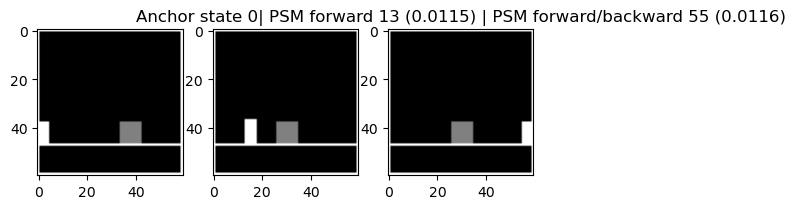

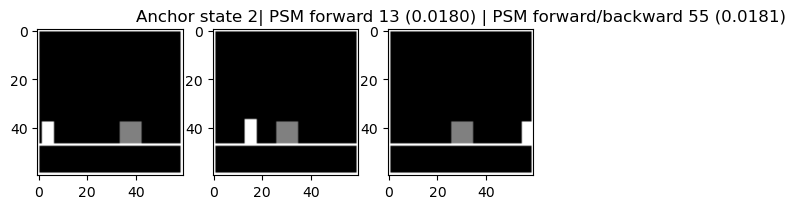

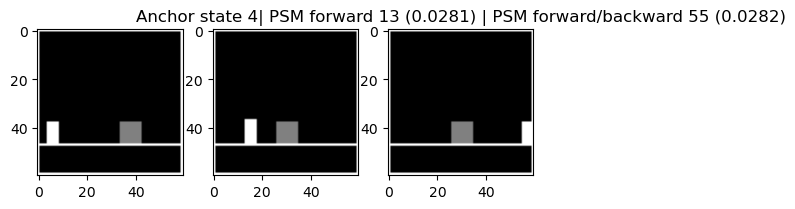

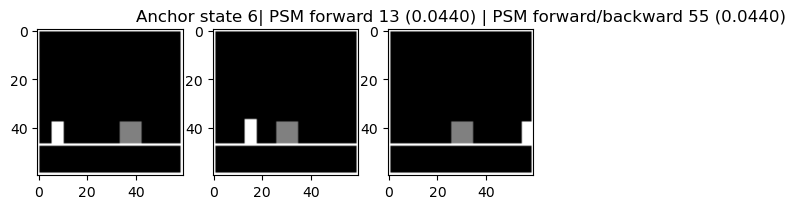

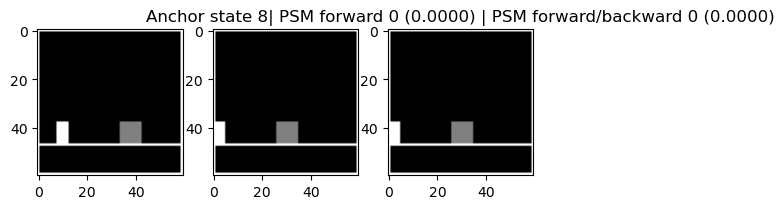

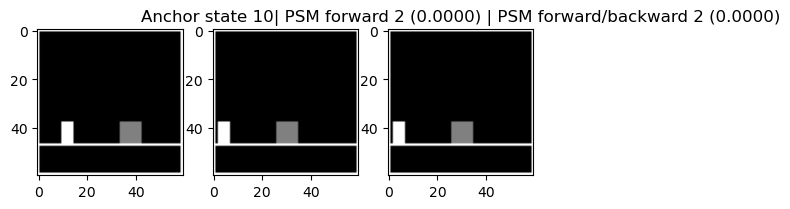

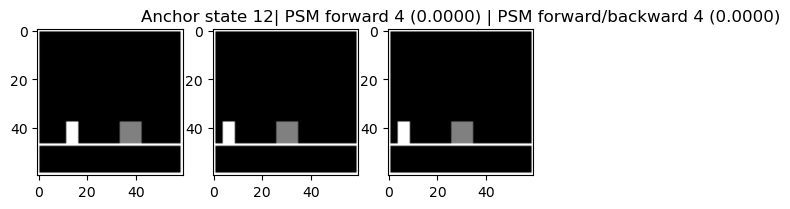

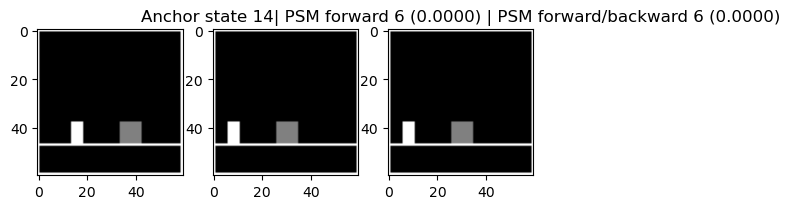

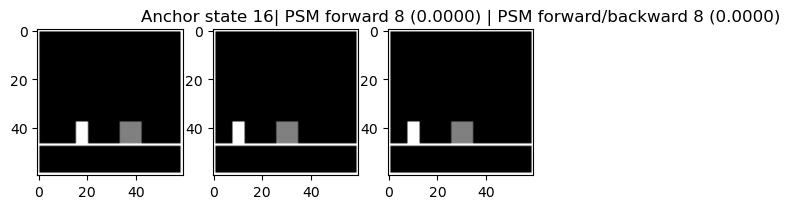

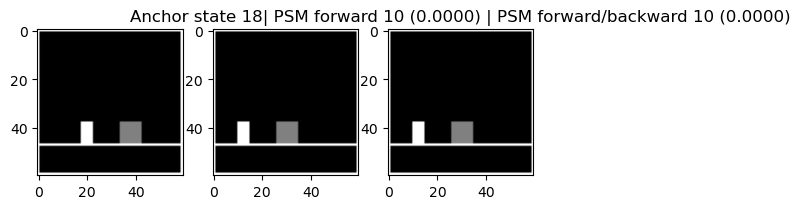

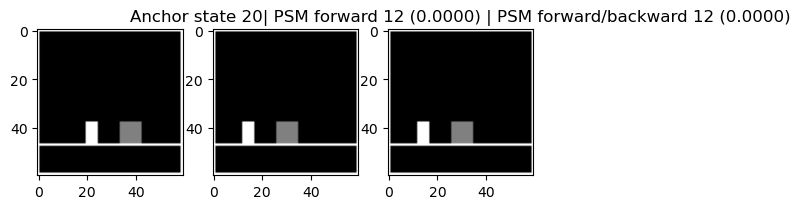

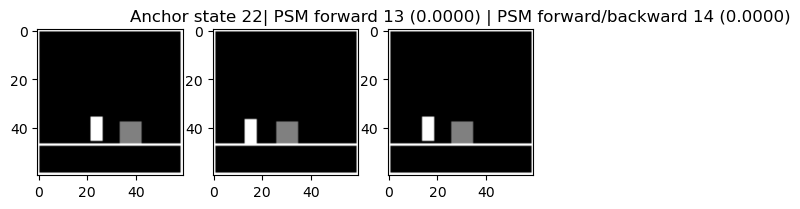

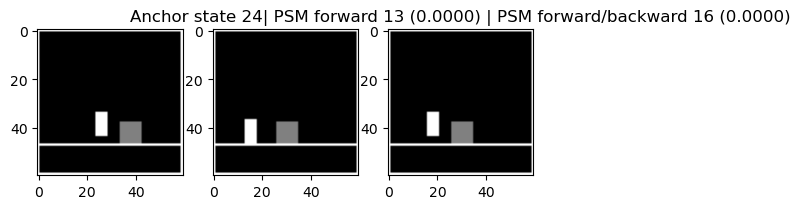

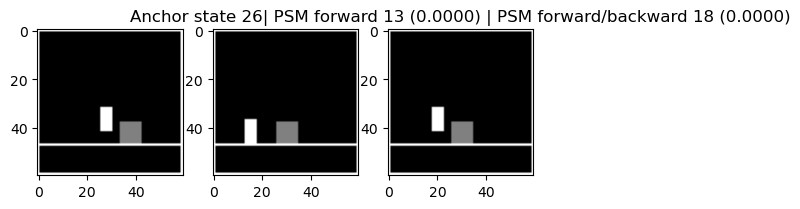

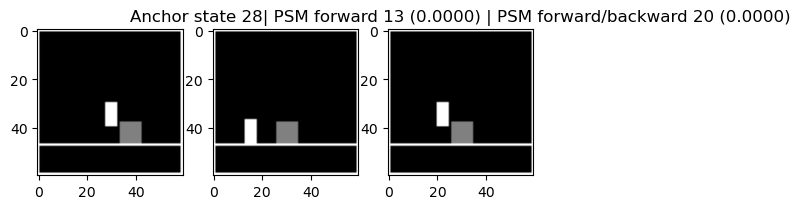

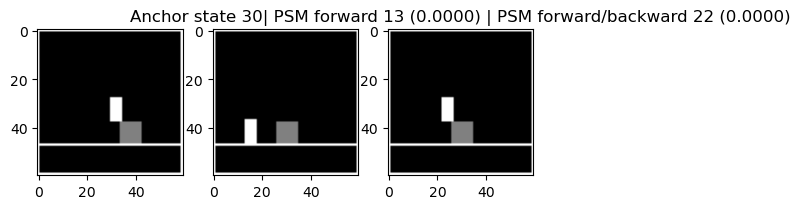

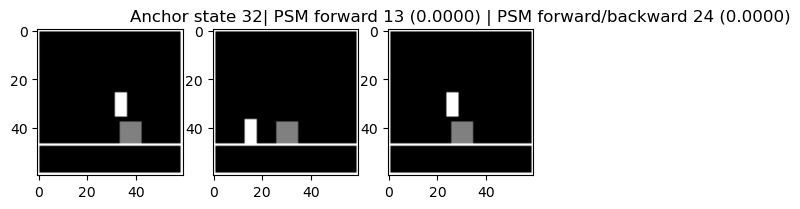

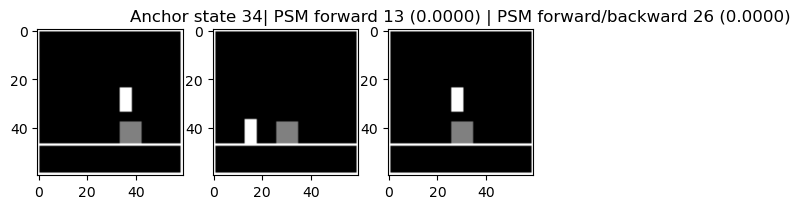

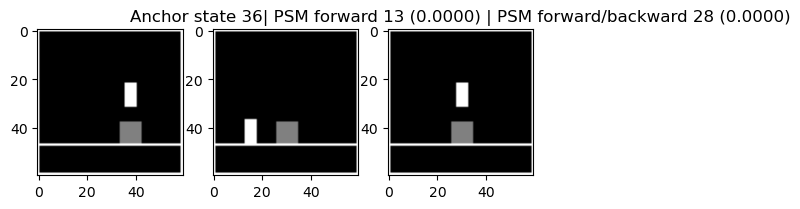

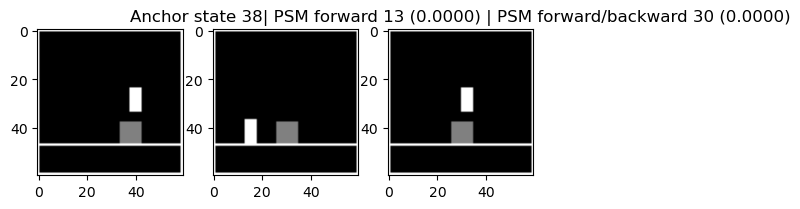

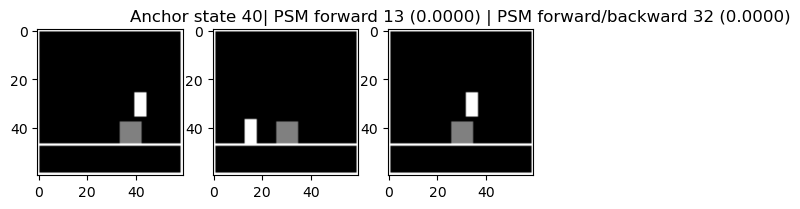

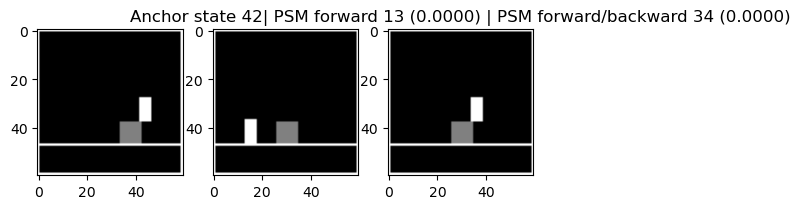

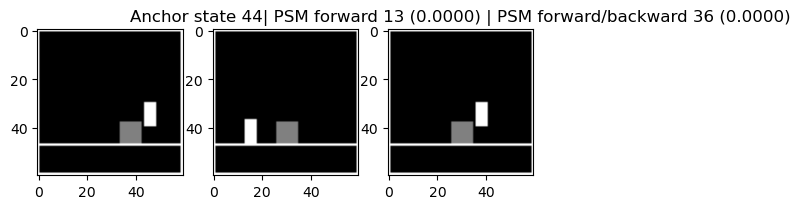

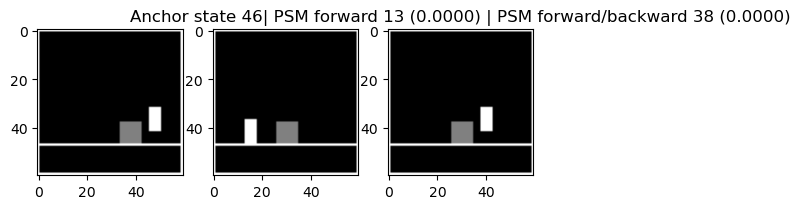

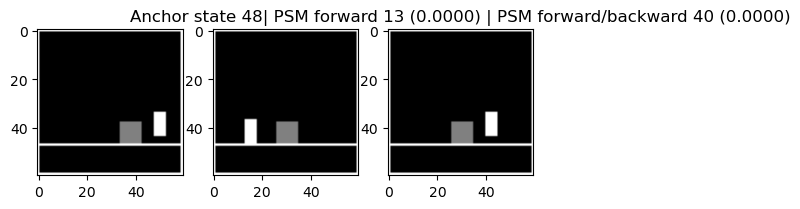

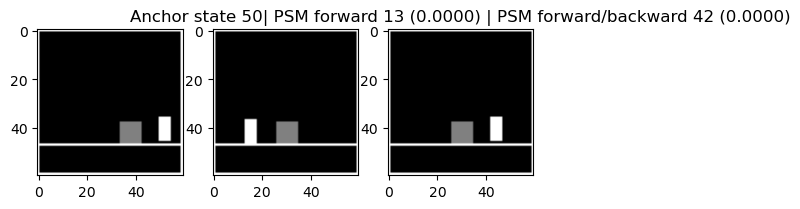

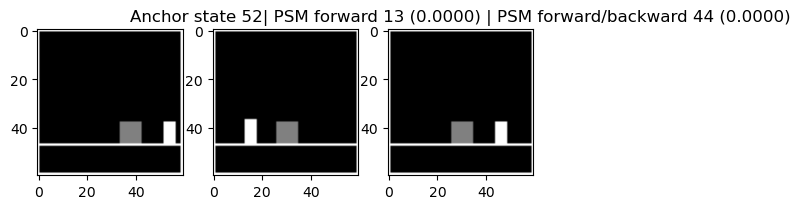

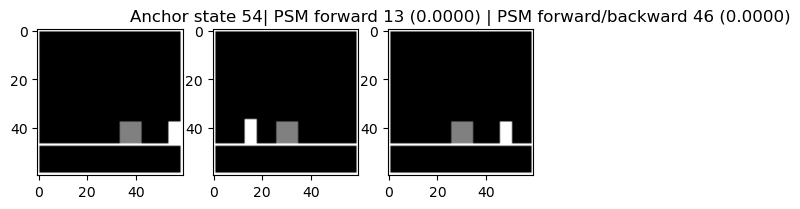

In [12]:
psm_forward = psm.psm_default(torch.tensor(actions_x), torch.tensor(actions_y), gamma=.8)
psm_fb = psm.psm_fb(torch.tensor(actions_x), torch.tensor(actions_y), gamma=.8)

psm_forward_fast = psm.psm_f_fast(torch.tensor(actions_x), torch.tensor(actions_y), gamma=.8)
psm_fb_fast = psm.psm_fb_fast(torch.tensor(actions_x), torch.tensor(actions_y), gamma=.8)

assert np.allclose(psm_forward, psm_forward_fast) , "Different psm values for fast and slow version!"
assert np.allclose(psm_fb, psm_fb_fast) , "Different psm values for fast and slow version!"

beta = 0.01
# psm_forward = np.exp(-psm_forward / beta)
# psm_fb = np.exp(-psm_fb / beta)

for compare_idx in range(0, len(actions_y)):                            
    # Given the state at index compare_idx, which state in Y is most similar?
    idx_forward = np.argmin(psm_forward[:, compare_idx])
    idx_fb = np.argmin(psm_fb[:,compare_idx])

    if compare_idx % 2 == 0:
        compare_imgs(
            states_y[compare_idx], 
            states_x[idx_forward], 
            states_x[idx_fb], 
            f"Anchor state {compare_idx}| PSM forward {idx_forward} ({psm_forward[idx_forward][compare_idx]:.4f}) | PSM forward/backward {idx_fb} ({psm_fb[idx_fb][compare_idx]:.4f})")


In [13]:
actions_x[18:18+10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
actions_y[10:10+10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tensor([0.9841, 0.9807, 0.9765, 0.9713, 0.9648, 0.9567, 0.9467, 0.9344, 0.9192,
        0.9006, 0.8778, 0.8502, 0.6688, 0.8502, 0.8778, 0.9006, 0.9192, 0.9344,
        0.9467, 0.9567, 0.9648, 0.9713, 0.9765, 0.9807, 0.9841, 0.9868, 0.9890,
        0.9907, 0.9921, 0.9932, 0.9941, 0.9948, 0.9954, 0.9959, 0.9962, 0.9965,
        0.9968, 0.9969, 0.9971, 0.9972, 0.9973, 0.9974, 0.9974, 0.9975, 0.9975,
        0.9976, 0.9976, 0.9976, 0.9976, 0.9976, 0.9977, 0.9977, 0.9977, 0.9977,
        0.9977, 0.9977])


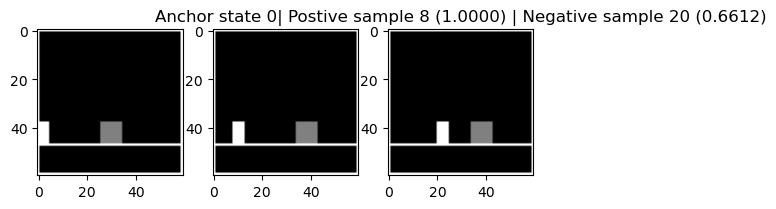

tensor([0.9808, 0.9774, 0.9733, 0.9680, 0.9616, 0.9535, 0.9436, 0.9313, 0.9162,
        0.8976, 0.8749, 0.8474, 0.6666, 0.8474, 0.8749, 0.8976, 0.9162, 0.9313,
        0.9436, 0.9535, 0.9616, 0.9680, 0.9733, 0.9774, 0.9808, 0.9835, 0.9857,
        0.9874, 0.9888, 0.9899, 0.9908, 0.9915, 0.9921, 0.9926, 0.9929, 0.9932,
        0.9934, 0.9936, 0.9938, 0.9939, 0.9940, 0.9941, 0.9941, 0.9942, 0.9942,
        0.9943, 0.9943, 0.9943, 0.9943, 0.9943, 0.9943, 0.9944, 0.9944, 0.9944,
        0.9944, 0.9944])


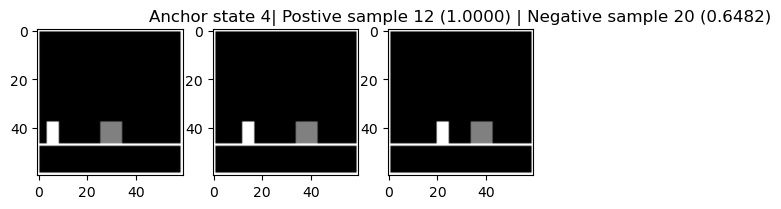

tensor([1.0000, 0.9695, 0.9654, 0.9602, 0.9538, 0.9458, 0.9360, 0.9238, 0.9088,
        0.8903, 0.8678, 0.8405, 0.6612, 0.8405, 0.8678, 0.8903, 0.9088, 0.9238,
        0.9360, 0.9458, 0.9538, 0.9602, 0.9654, 0.9695, 0.9729, 0.9756, 0.9777,
        0.9794, 0.9808, 0.9819, 0.9828, 0.9835, 0.9841, 0.9845, 0.9849, 0.9852,
        0.9854, 0.9856, 0.9858, 0.9859, 0.9860, 0.9860, 0.9861, 0.9862, 0.9862,
        0.9862, 0.9863, 0.9863, 0.9863, 0.9863, 0.9863, 0.9863, 0.9863, 0.9863,
        0.9863, 0.9863])


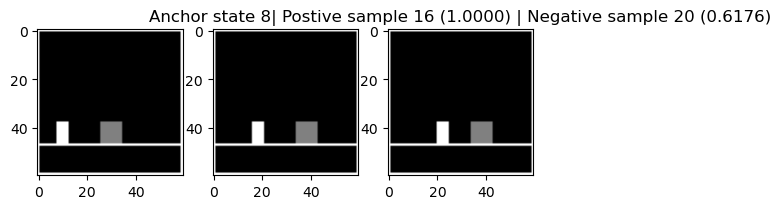

tensor([0.9538, 0.9505, 0.9465, 0.9414, 1.0000, 0.9273, 0.9176, 0.9057, 0.8909,
        0.8729, 0.8508, 0.8240, 0.6482, 0.8240, 0.8508, 0.8729, 0.8909, 0.9057,
        0.9176, 0.9273, 0.9351, 0.9414, 0.9465, 0.9505, 0.9538, 0.9564, 0.9585,
        0.9602, 0.9616, 0.9627, 0.9635, 0.9642, 0.9648, 0.9652, 0.9656, 0.9659,
        0.9661, 0.9663, 0.9664, 0.9665, 0.9666, 0.9667, 0.9668, 0.9668, 0.9668,
        0.9669, 0.9669, 0.9669, 0.9669, 0.9670, 0.9670, 0.9670, 0.9670, 0.9670,
        0.9670, 0.9670])


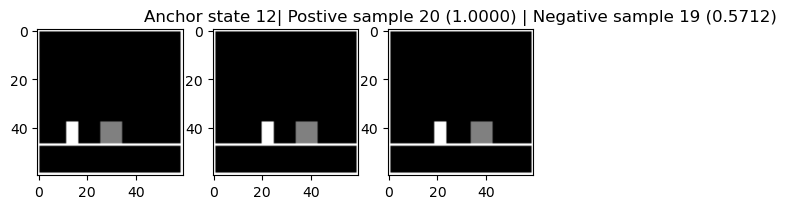

tensor([0.9088, 0.9057, 0.9018, 0.8969, 0.8909, 0.8835, 0.8743, 0.8629, 1.0000,
        0.8317, 0.8106, 0.7851, 0.6176, 0.7851, 0.8106, 0.8317, 0.8489, 0.8629,
        0.8743, 0.8835, 0.8909, 0.8969, 0.9018, 0.9057, 0.9088, 0.9113, 0.9133,
        0.9149, 0.9162, 0.9172, 0.9180, 0.9187, 0.9192, 0.9196, 0.9200, 0.9203,
        0.9205, 0.9206, 0.9208, 0.9209, 0.9210, 0.9211, 0.9211, 0.9212, 0.9212,
        0.9212, 0.9213, 0.9213, 0.9213, 0.9213, 0.9213, 0.9213, 0.9213, 0.9213,
        0.9213, 0.9213])


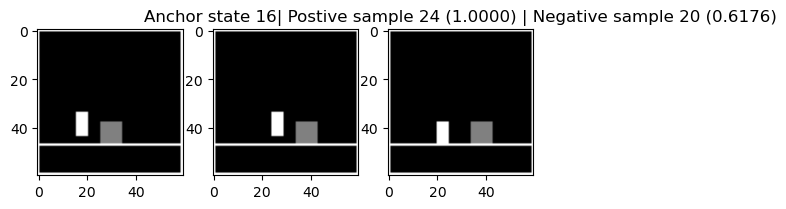

tensor([0.6612, 0.6589, 0.6561, 0.6526, 0.6482, 0.6428, 0.6361, 0.6278, 0.6176,
        0.6051, 0.5898, 0.5712, 1.0000, 0.5712, 0.5898, 0.6051, 0.6176, 0.6278,
        0.6361, 0.6428, 0.6482, 0.6526, 0.6561, 0.6589, 0.6612, 0.6630, 0.6644,
        0.6656, 0.6666, 0.6673, 0.6679, 0.6684, 0.6688, 0.6691, 0.6693, 0.6695,
        0.6697, 0.6698, 0.6699, 0.6700, 0.6701, 0.6701, 0.6702, 0.6702, 0.6702,
        0.6702, 0.6703, 0.6703, 0.6703, 0.6703, 0.6703, 0.6703, 0.6703, 0.6703,
        0.6703, 0.6703])


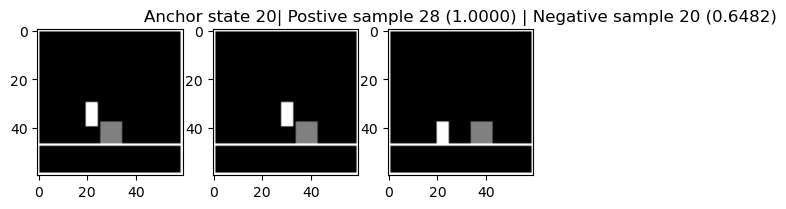

tensor([0.9088, 0.9057, 0.9018, 0.8969, 0.8909, 0.8835, 0.8743, 0.8629, 0.8489,
        0.8317, 0.8106, 0.7851, 0.6176, 0.7851, 0.8106, 0.8317, 1.0000, 0.8629,
        0.8743, 0.8835, 0.8909, 0.8969, 0.9018, 0.9057, 0.9088, 0.9113, 0.9133,
        0.9149, 0.9162, 0.9172, 0.9180, 0.9187, 0.9192, 0.9196, 0.9200, 0.9203,
        0.9205, 0.9206, 0.9208, 0.9209, 0.9210, 0.9211, 0.9211, 0.9212, 0.9212,
        0.9212, 0.9213, 0.9213, 0.9213, 0.9213, 0.9213, 0.9213, 0.9213, 0.9213,
        0.9213, 0.9213])


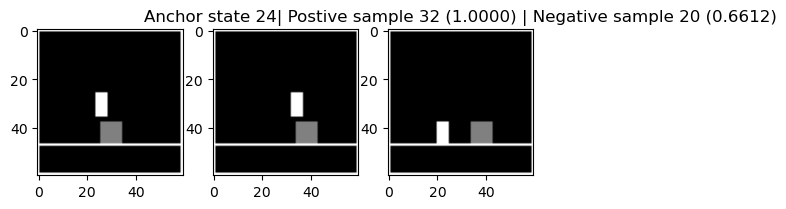

tensor([0.9538, 0.9505, 0.9465, 0.9414, 0.9351, 0.9273, 0.9176, 0.9057, 0.8909,
        0.8729, 0.8508, 0.8240, 0.6482, 0.8240, 0.8508, 0.8729, 0.8909, 0.9057,
        0.9176, 0.9273, 1.0000, 0.9414, 0.9465, 0.9505, 0.9538, 0.9564, 0.9585,
        0.9602, 0.9616, 0.9627, 0.9635, 0.9642, 0.9648, 0.9652, 0.9656, 0.9659,
        0.9661, 0.9663, 0.9664, 0.9665, 0.9666, 0.9667, 0.9668, 0.9668, 0.9668,
        0.9669, 0.9669, 0.9669, 0.9669, 0.9670, 0.9670, 0.9670, 0.9670, 0.9670,
        0.9670, 0.9670])


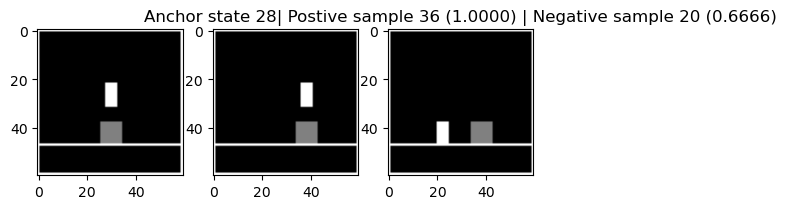

tensor([0.9729, 0.9695, 0.9654, 0.9602, 0.9538, 0.9458, 0.9360, 0.9238, 0.9088,
        0.8903, 0.8678, 0.8405, 0.6612, 0.8405, 0.8678, 0.8903, 0.9088, 0.9238,
        0.9360, 0.9458, 0.9538, 0.9602, 0.9654, 0.9695, 1.0000, 0.9756, 0.9777,
        0.9794, 0.9808, 0.9819, 0.9828, 0.9835, 0.9841, 0.9845, 0.9849, 0.9852,
        0.9854, 0.9856, 0.9858, 0.9859, 0.9860, 0.9860, 0.9861, 0.9862, 0.9862,
        0.9862, 0.9863, 0.9863, 0.9863, 0.9863, 0.9863, 0.9863, 0.9863, 0.9863,
        0.9863, 0.9863])


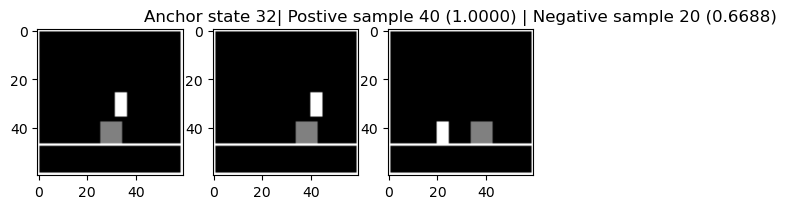

tensor([0.9808, 0.9774, 0.9733, 0.9680, 0.9616, 0.9535, 0.9436, 0.9313, 0.9162,
        0.8976, 0.8749, 0.8474, 0.6666, 0.8474, 0.8749, 0.8976, 0.9162, 0.9313,
        0.9436, 0.9535, 0.9616, 0.9680, 0.9733, 0.9774, 0.9808, 0.9835, 0.9857,
        0.9874, 1.0000, 0.9899, 0.9908, 0.9915, 0.9921, 0.9926, 0.9929, 0.9932,
        0.9934, 0.9936, 0.9938, 0.9939, 0.9940, 0.9941, 0.9941, 0.9942, 0.9942,
        0.9943, 0.9943, 0.9943, 0.9943, 0.9943, 0.9943, 0.9944, 0.9944, 0.9944,
        0.9944, 0.9944])


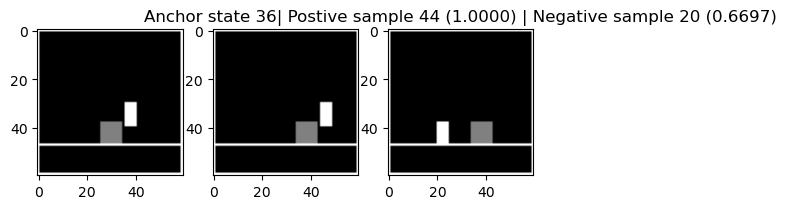

tensor([0.9841, 0.9807, 0.9765, 0.9713, 0.9648, 0.9567, 0.9467, 0.9344, 0.9192,
        0.9006, 0.8778, 0.8502, 0.6688, 0.8502, 0.8778, 0.9006, 0.9192, 0.9344,
        0.9467, 0.9567, 0.9648, 0.9713, 0.9765, 0.9807, 0.9841, 0.9868, 0.9890,
        0.9907, 0.9921, 0.9932, 0.9941, 0.9948, 1.0000, 0.9959, 0.9962, 0.9965,
        0.9968, 0.9969, 0.9971, 0.9972, 0.9973, 0.9974, 0.9974, 0.9975, 0.9975,
        0.9976, 0.9976, 0.9976, 0.9976, 0.9976, 0.9977, 0.9977, 0.9977, 0.9977,
        0.9977, 0.9977])


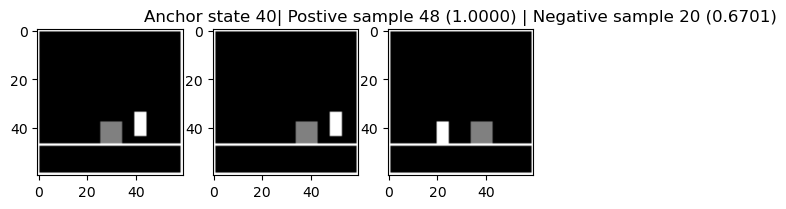

tensor([0.9854, 0.9820, 0.9778, 0.9726, 0.9661, 0.9580, 0.9480, 0.9357, 0.9205,
        0.9018, 0.8790, 0.8513, 0.6697, 0.8513, 0.8790, 0.9018, 0.9205, 0.9357,
        0.9480, 0.9580, 0.9661, 0.9726, 0.9778, 0.9820, 0.9854, 0.9881, 0.9903,
        0.9921, 0.9934, 0.9946, 0.9955, 0.9962, 0.9968, 0.9972, 0.9976, 0.9979,
        1.0000, 0.9983, 0.9985, 0.9986, 0.9987, 0.9987, 0.9988, 0.9989, 0.9989,
        0.9989, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990,
        0.9990, 0.9990])


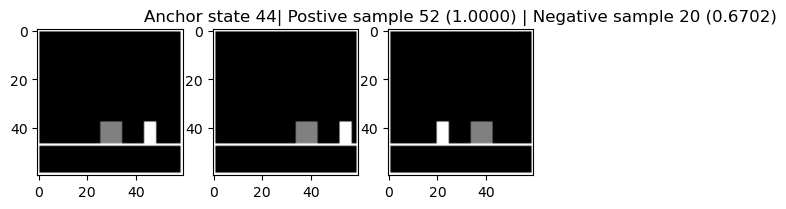

tensor([0.9860, 0.9826, 0.9784, 0.9731, 0.9666, 0.9586, 0.9486, 0.9362, 0.9210,
        0.9023, 0.8795, 0.8518, 0.6701, 0.8518, 0.8795, 0.9023, 0.9210, 0.9362,
        0.9486, 0.9586, 0.9666, 0.9731, 0.9784, 0.9826, 0.9860, 0.9887, 0.9909,
        0.9926, 0.9940, 0.9951, 0.9960, 0.9967, 0.9973, 0.9978, 0.9981, 0.9984,
        0.9987, 0.9989, 0.9990, 0.9991, 1.0000, 0.9993, 0.9994, 0.9994, 0.9995,
        0.9995, 0.9995, 0.9995, 0.9995, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996,
        0.9996, 0.9996])


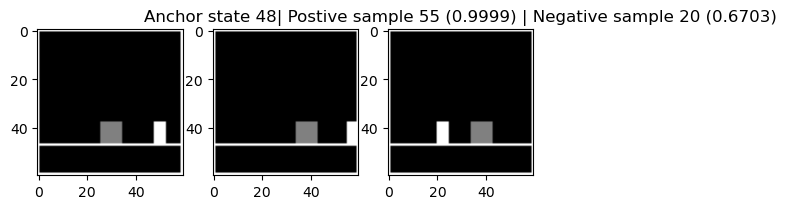

tensor([0.9862, 0.9828, 0.9786, 0.9734, 0.9668, 0.9588, 0.9488, 0.9364, 0.9212,
        0.9025, 0.8797, 0.8520, 0.6702, 0.8520, 0.8797, 0.9025, 0.9212, 0.9364,
        0.9488, 0.9588, 0.9668, 0.9734, 0.9786, 0.9828, 0.9862, 0.9889, 0.9911,
        0.9928, 0.9942, 0.9953, 0.9962, 0.9970, 0.9975, 0.9980, 0.9984, 0.9987,
        0.9989, 0.9991, 0.9992, 0.9994, 0.9995, 0.9995, 0.9996, 0.9996, 1.0000,
        0.9997, 0.9997, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998,
        0.9998, 0.9998])


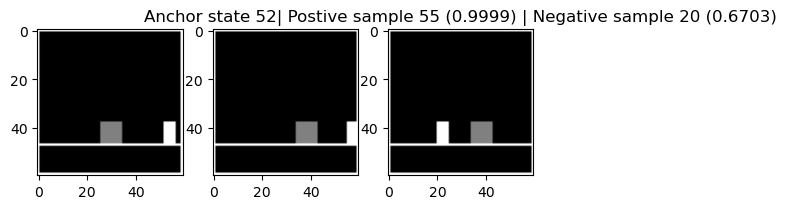

In [17]:
# Some experiments for triplet loss
psm_mat = psm.psm_fb_fast(torch.tensor(actions_x), torch.tensor(actions_y), gamma=.8)

beta = 5
psm_mat = np.exp(-psm_mat/beta)

for compare_idx in range(0, len(actions_x)):                            
    # Given the state at index compare_idx, which state in Y is most similar?
    idx_positive = np.argmax(psm_mat[compare_idx, :])
    idx_negative = np.argmin(psm_mat[compare_idx, :])

    if compare_idx % 4 == 0:
        print(psm_mat[:,compare_idx])
        compare_imgs(
            states_x[compare_idx], 
            states_y[idx_positive], 
            states_y[idx_negative], 
            f"Anchor state {compare_idx}| Postive sample {idx_positive} ({psm_mat[compare_idx][idx_positive]:.4f}) | Negative sample {idx_negative} ({psm_mat[compare_idx][idx_negative]:.4f})")
